<a href="https://colab.research.google.com/github/verneh/mdetr/blob/main/MDETR_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MDETR - Modulated Detection for End-to-End Multi-Modal Understanding

Experimenting with the demo notebook for MDETR. A show-case of detection, segmentation and question answering



## Preliminaries

This section contains the initial boilerplate. Run it first.

In [1]:
! pip install timm transformers

     |████████████████████████████████| 296kB 7.8MB/s 
     |████████████████████████████████| 2.1MB 13.2MB/s 
     |████████████████████████████████| 901kB 33.8MB/s 
     |████████████████████████████████| 3.3MB 55.3MB/s 


In [2]:
import torch
from PIL import Image
import requests
import torchvision.transforms as T
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F
import numpy as np
from skimage.measure import find_contours

from matplotlib import patches,  lines
from matplotlib.patches import Polygon

torch.set_grad_enabled(False);

In [3]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [4]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def plot_results(pil_img, scores, boxes, labels, masks=None):
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if masks is None:
      masks = [None for _ in range(len(scores))]
    assert len(scores) == len(boxes) == len(labels) == len(masks)
    for s, (xmin, ymin, xmax, ymax), l, mask, c in zip(scores, boxes.tolist(), labels, masks, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

        if mask is None:
          continue
        np_image = apply_mask(np_image, mask, c)

        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
          # Subtract the padding and flip (y, x) to (x, y)
          verts = np.fliplr(verts) - 1
          p = Polygon(verts, facecolor="none", edgecolor=c)
          ax.add_patch(p)


    plt.imshow(np_image)
    plt.axis('off')
    plt.show()


def add_res(results, ax, color='green'):
    #for tt in results.values():
    if True:
        bboxes = results['boxes']
        labels = results['labels']
        scores = results['scores']
        #keep = scores >= 0.0
        #bboxes = bboxes[keep].tolist()
        #labels = labels[keep].tolist()
        #scores = scores[keep].tolist()
    #print(torchvision.ops.box_iou(tt['boxes'].cpu().detach(), torch.as_tensor([[xmin, ymin, xmax, ymax]])))
    
    colors = ['purple', 'yellow', 'red', 'green', 'orange', 'pink']
    
    for i, (b, ll, ss) in enumerate(zip(bboxes, labels, scores)):
        ax.add_patch(plt.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], fill=False, color=colors[i], linewidth=3))
        cls_name = ll if isinstance(ll,str) else CLASSES[ll]
        text = f'{cls_name}: {ss:.2f}'
        print(text)
        ax.text(b[0], b[1], text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

## Detection

In this section, we show the performance of our pre-trained model on modulated detection. 
Keep in mind that this model wasn't fine-tuned for any specific task.

We load the model from torch hub

In [5]:
model, postprocessor = torch.hub.load('ashkamath/mdetr:main', 'mdetr_efficientnetB5', pretrained=True, return_postprocessor=True)
model = model.cuda()
model.eval();

Downloading: "https://github.com/ashkamath/mdetr/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ns-6f26d0cf.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ns-6f26d0cf.pth


Downloading: "https://zenodo.org/record/4721981/files/pretrained_EB5_checkpoint.pth" to /root/.cache/torch/hub/checkpoints/pretrained_EB5_checkpoint.pth


Next, we retrieve an image on which we wish to test the model. Here, we use an image from the validation set of COCO

In [6]:
url = "https://www.nextstagedesign.com/wp-content/uploads/2015/03/energy-efficient-appliances.jpg"
im = Image.open(requests.get(url, stream=True).raw)

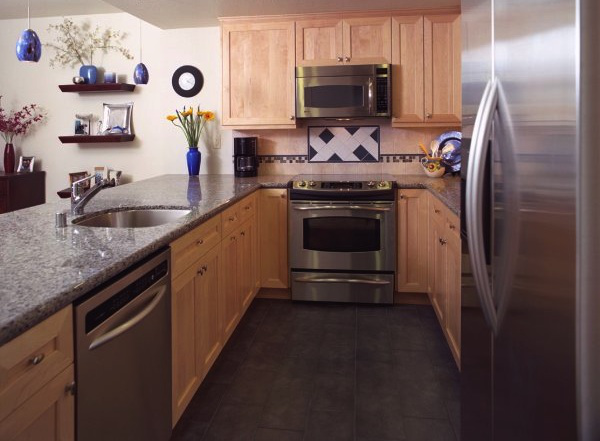

In [7]:
im

In [8]:
def plot_inference(im, caption):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(im).unsqueeze(0).cuda()

  # propagate through the model
  memory_cache = model(img, [caption], encode_and_save=True)
  outputs = model(img, [caption], encode_and_save=False, memory_cache=memory_cache)

  # keep only predictions with 0.7+ confidence
  probas = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
  keep = (probas > 0.7).cpu()

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].cpu()[0, keep], im.size)

  # Extract the text spans predicted by each box
  positive_tokens = (outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
  predicted_spans = defaultdict(str)
  for tok in positive_tokens:
    item, pos = tok
    if pos < 255:
        span = memory_cache["tokenized"].token_to_chars(0, pos)
        predicted_spans [item] += " " + caption[span.start:span.end]

  labels = [predicted_spans [k] for k in sorted(list(predicted_spans .keys()))]
  plot_results(im, probas[keep], bboxes_scaled, labels)

Considered all objects in the image

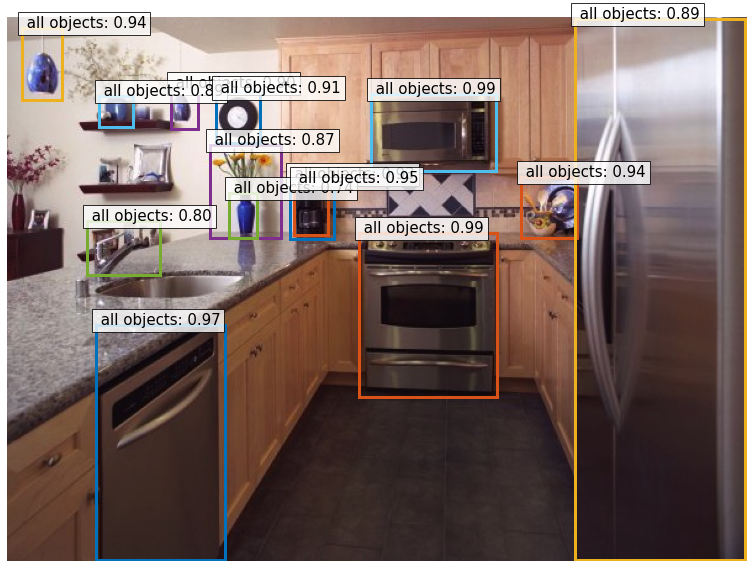

In [14]:
plot_inference(im, "all objects")

We can now ask to single out specific instances

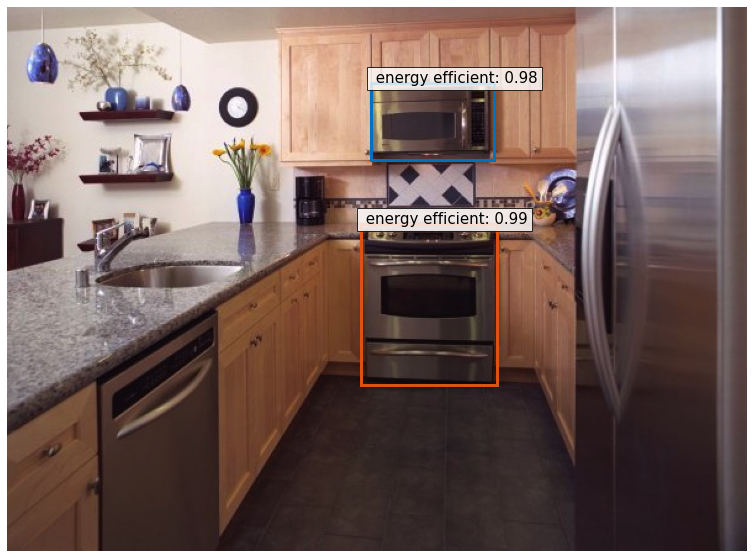

In [15]:
plot_inference(im, "energy efficient")

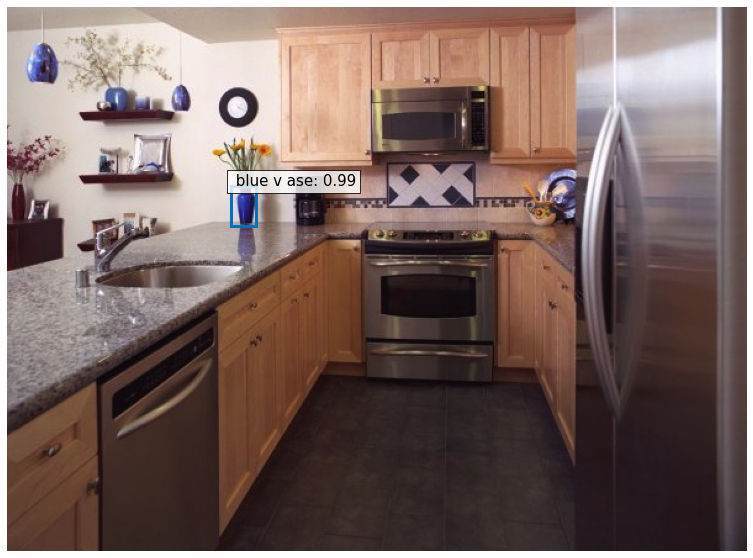

In [16]:
plot_inference(im, "blue vase")

It can also find non-salient objects

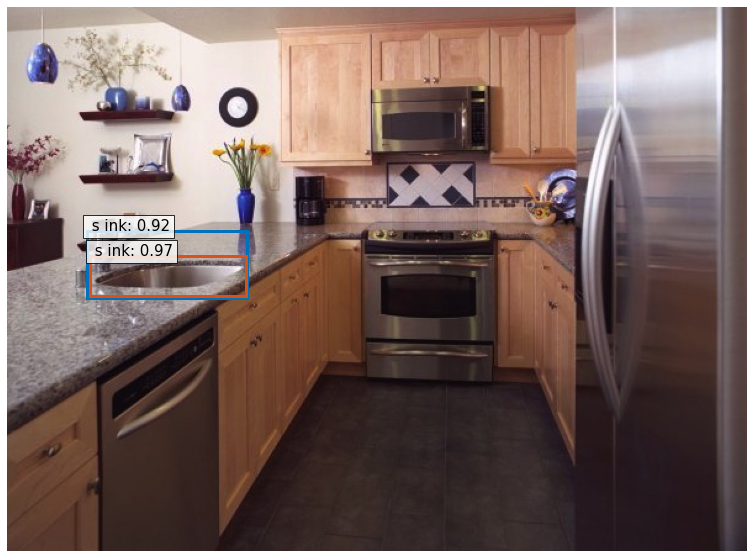

In [25]:
plot_inference(im, "sink")

Note that this model is trained with almost no negatives: during pre-training each text query is almost always associated to an object in the image. As a result, the model is biased to try to always output a detection, even if the object is not actually there (usually by picking the salient objects).

See the LVIS model for a model fine-tuned with negatives.

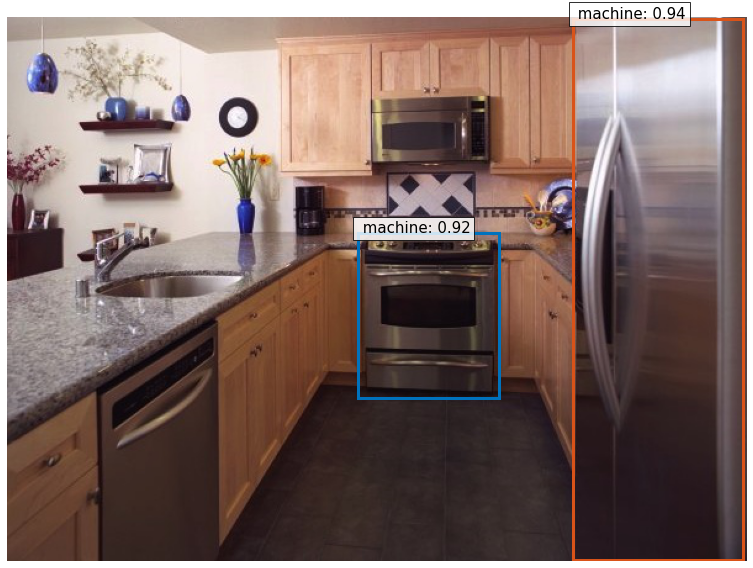

In [26]:
plot_inference(im, "washing machine")

## Segmentation

To show-case segmentation, we use our model fine-tuned on phrase-cut. The captions in phrase-cut are usually very short, and contain ony one sentence. Keep this in mind while building your own prompts.

In [27]:
model_pc = torch.hub.load('ashkamath/mdetr:main', 'mdetr_efficientnetB3_phrasecut', pretrained=True, return_postprocessor=False)
model_pc = model_pc.cuda()
model_pc.eval();

Using cache found in /root/.cache/torch/hub/ashkamath_mdetr_main
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_ns-9d44bf68.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_ns-9d44bf68.pth
Downloading: "https://zenodo.org/record/4721981/files/phrasecut_EB3_checkpoint.pth" to /root/.cache/torch/hub/checkpoints/phrasecut_EB3_checkpoint.pth


In [28]:
def plot_inference_segmentation(im, caption):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(im).unsqueeze(0).cuda()

  # propagate through the model
  outputs = model_pc(img, [caption])

  # keep only predictions with 0.9+ confidence
  probas = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
  keep = (probas > 0.9).cpu()

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].cpu()[0, keep], im.size)

  # Interpolate masks to the correct size
  w, h = im.size
  masks = F.interpolate(outputs["pred_masks"], size=(h, w), mode="bilinear", align_corners=False)
  masks = masks.cpu()[0, keep].sigmoid() > 0.5

  tokenized = model_pc.detr.transformer.tokenizer.batch_encode_plus([caption], padding="longest", return_tensors="pt").to(img.device)

  # Extract the text spans predicted by each box
  positive_tokens = (outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
  predicted_spans = defaultdict(str)
  for tok in positive_tokens:
    item, pos = tok
    if pos < 255:
        span = tokenized.token_to_chars(0, pos)
        predicted_spans [item] += " " + caption[span.start:span.end]

  labels = [predicted_spans [k] for k in sorted(list(predicted_spans .keys()))]
  plot_results(im, probas[keep], bboxes_scaled, labels, masks)
  return outputs

In [29]:
url = "https://www.lg.com/us/images/CA/features/HA_XHA_Kitchen_LG.com_Optimization_KitchenCatPage_Herocard.jpg"
im2 = Image.open(requests.get(url, stream=True).raw)


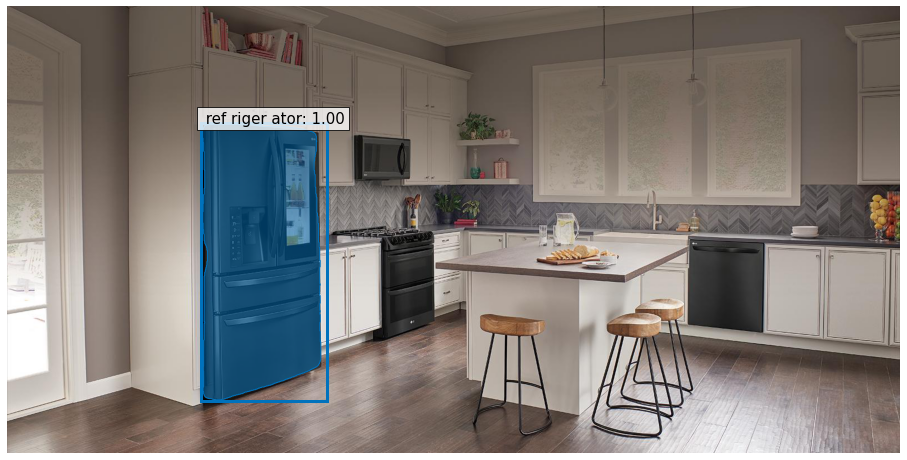

In [30]:
outputs = plot_inference_segmentation(im2, "refrigerator")

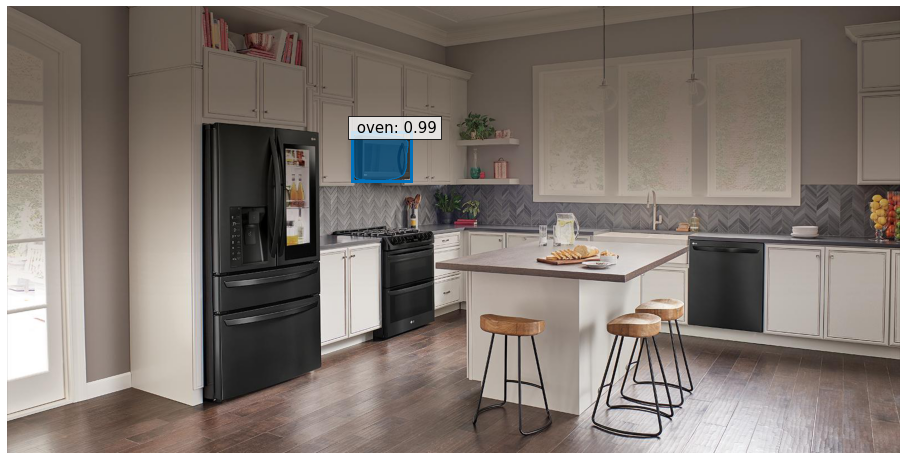

In [31]:
outputs = plot_inference_segmentation(im2, "oven")

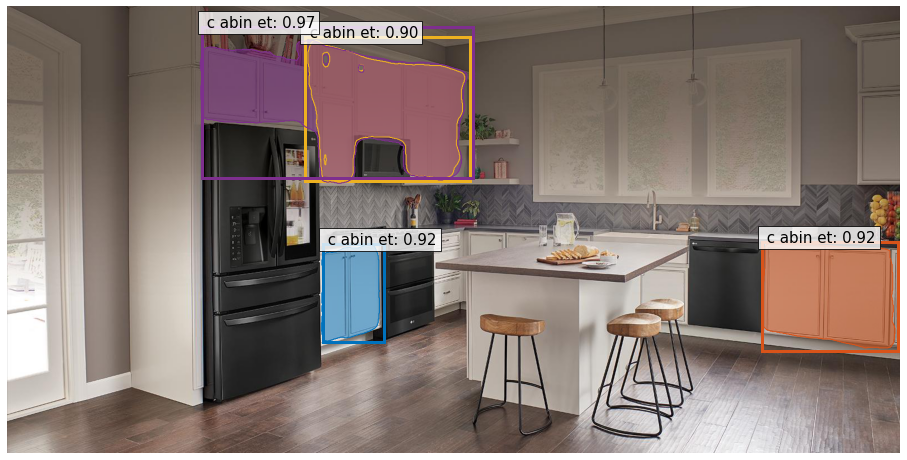

In [32]:
outputs = plot_inference_segmentation(im2, "cabinet")

## Question answering

Finally, we demonstrate the inference on visual question answering. This model was trained on GQA, hence the questions must be similar (in particular, GQA doesn't contain counting questions)

In [33]:
model_qa = torch.hub.load('ashkamath/mdetr:main', 'mdetr_efficientnetB5_gqa', pretrained=True, return_postprocessor=False)
model_qa = model_qa.cuda()
model_qa.eval();

Using cache found in /root/.cache/torch/hub/ashkamath_mdetr_main
Downloading: "https://zenodo.org/record/4721981/files/gqa_EB5_checkpoint.pth" to /root/.cache/torch/hub/checkpoints/gqa_EB5_checkpoint.pth


We download the mapping from the answers to their id.

In [34]:
import json
answer2id_by_type = json.load(requests.get("https://nyu.box.com/shared/static/j4rnpo8ixn6v0iznno2pim6ffj3jyaj8.json", stream=True).raw)
id2answerbytype = {}                                                       
for ans_type in answer2id_by_type.keys():                        
    curr_reversed_dict = {v: k for k, v in answer2id_by_type[ans_type].items()}
    id2answerbytype[ans_type] = curr_reversed_dict                             

In [35]:
def plot_inference_qa(im, caption):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(im).unsqueeze(0).cuda()

  # propagate through the model
  memory_cache = model_qa(img, [caption], encode_and_save=True)
  outputs = model_qa(img, [caption], encode_and_save=False, memory_cache=memory_cache)

  # keep only predictions with 0.7+ confidence
  probas = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
  keep = (probas > 0.7).cpu()

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].cpu()[0, keep], im.size)

  # Extract the text spans predicted by each box
  positive_tokens = (outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
  predicted_spans = defaultdict(str)
  for tok in positive_tokens:
    item, pos = tok
    if pos < 255:
        span = memory_cache["tokenized"].token_to_chars(0, pos)
        predicted_spans [item] += " " + caption[span.start:span.end]

  labels = [predicted_spans [k] for k in sorted(list(predicted_spans .keys()))]
  plot_results(im, probas[keep], bboxes_scaled, labels)

  # Classify the question type
  type_conf, type_pred = outputs["pred_answer_type"].softmax(-1).max(-1)
  ans_type = type_pred.item()
  types = ["obj", "attr", "rel", "global", "cat"]

  ans_conf, ans = outputs[f"pred_answer_{types[ans_type]}"][0].softmax(-1).max(-1)
  answer = id2answerbytype[f"answer_{types[ans_type]}"][ans.item()]
  print(f"Predicted answer: {answer}\t confidence={round(100 * type_conf.item() * ans_conf.item(), 2)}")

In [43]:
url = "https://assets.hmetro.com.my/images/articles/obj16688609_1564058465.jpg"
im3 = Image.open(requests.get(url, stream=True).raw)

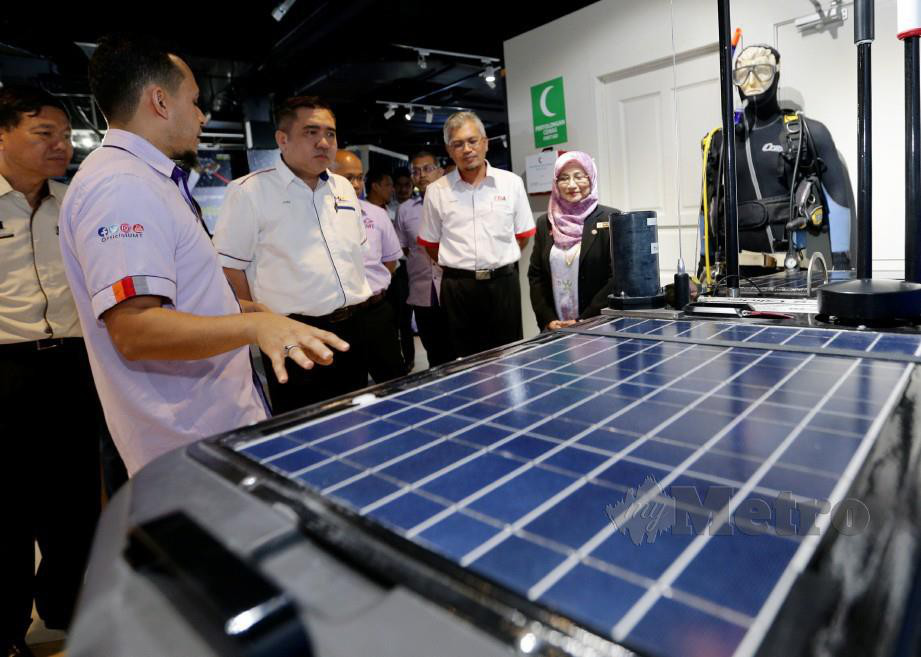

In [44]:
im3

During question answering, we can still plot the boxes that are detected by the model, thus giving us a hint of what's happening under the hood.

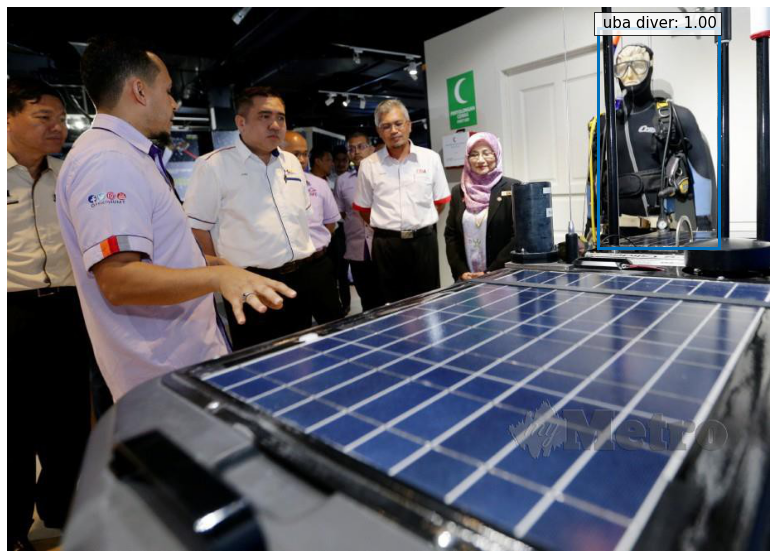

Predicted answer: yes	 confidence=98.2


In [48]:
plot_inference_qa(im3, "Is there a scuba diver?")

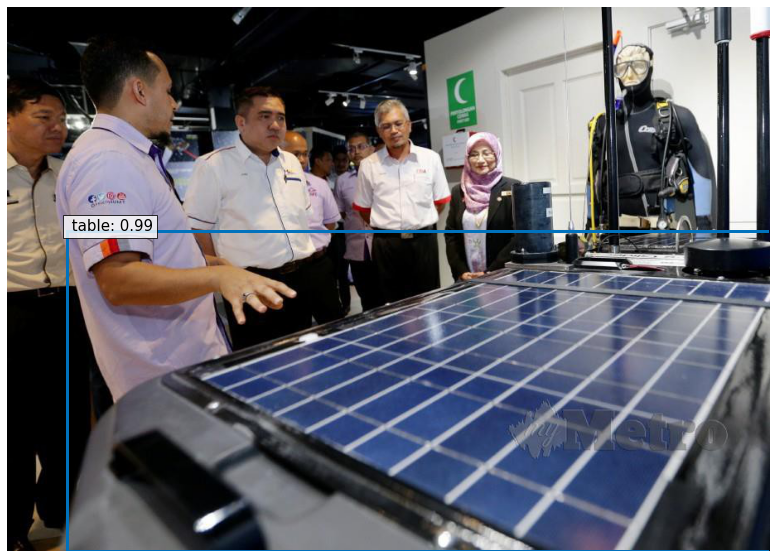

Predicted answer: tray	 confidence=20.3


In [49]:
plot_inference_qa(im3, "What is on the table?")

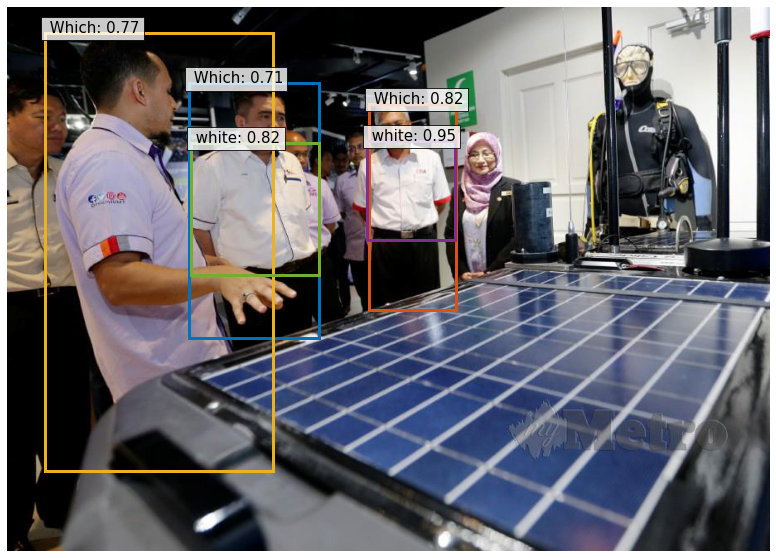

Predicted answer: cars	 confidence=23.8


In [51]:
plot_inference_qa(im3, "Which individuals are wearing white shirts?")